In [1]:
import os
import numpy as np
import datetime
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from curve import LinearCurve, QuadraticCurve, CubicCurve, CubicSplineCurve
from pricer import CurvePricer, SimplePricer, DefaultPricer
from derivative import ZeroCouponBond, CallOnZeroCouponBond, PutOnZeroCouponBond, Caplet, Floorlet, Cap, Floor
from calibration import calibration, array_to_param, own_calibration, define_optimization_function, squared, generate_bounds
from dcf import dcf_generator

# RNG Seeding
gen_seed, opt_seed = 743453, 894520

path = r'C:/Users/Miikka/PycharmProjects/gradu/'
file = 'euribor.csv'

euribor = pd.read_csv(path+file, sep=';', header=0)

fun = lambda x: datetime.datetime.strptime(x, '%d.%m.%Y')

euribor['Date'] = euribor['Date'].apply(fun)

euribor_indexed = euribor.set_index(keys='Date')

length = euribor.shape[0]

d = {}
zeros = {}

for i in range(length):
    day = euribor.iloc[i, 0].date()
    d[day] = {}
    rates = euribor_indexed.iloc[i, :]

    w1 = day + relativedelta(days=+7)
    w2 = day + relativedelta(days=+14)
    m1 = day + relativedelta(months=+1)
    m3 = day + relativedelta(months=+3)
    m6 = day + relativedelta(months=+6)
    y1 = day + relativedelta(years=+1)

    dates = [w1, w2, m1, m3, m6, y1]

    rates = pd.DataFrame(dict(Rates=list(rates)), index=dates)

    d[day]['curve'] = CubicSplineCurve(today=day)
    d[day]['curve'].give_rates(rates/100)

    interpolated = d[day]['curve'].interpolation(dates=dates)
    zeros = interpolated['Zeros']

    d[day]['pricer'] = SimplePricer(today=day)
    d[day]['zeros'] = [ZeroCouponBond(maturity=dates[j],
                                      market_price=price) for j, price in enumerate(zeros)]
    zeros[day]= [zero.calibrate for zero in d[day]['zeros']]

first_day = euribor['Date'][0].date()

bounds = dict(shift=(-0.2, 0.2),
              alpha=(0.0001, 3),
              theta=(0, 0.25),
              sigma=(0.0001, 0.25),
              x0=(0.0001, 0.1),
              k=(0.0001, 3),
              nu=(0.0001, 0.25),
              rho=(-0.99, 0.99),
              y0=(-0.2, 0.2))

def series_calibration(M, N, gen_seed, opt_seed, d, bounds):
    
    res_d = {}

    res, res_evo, calibration_object, duration = own_calibration(M=M,
                                                                 N=N,
                                                                 gen_seed=gen_seed,
                                                                 opt_seed=opt_seed,
                                                                 pricer=d[first_day]['pricer'],
                                                                 instruments=d[first_day]['zeros'],
                                                                 bounds=bounds,
                                                                 generational_cycle=25,
                                                                 size=2048)
    
    x0 = res.x

    bnds = generate_bounds(M=M, N=N, **bounds)

    results = {}

    for i in range(length):
        day = euribor.iloc[i, 0].date()
        
        pricer = d[day]['pricer']
        zeros = d[day]['zeros']

        optimization_fun = define_optimization_function(squared,
                                                        M=M, 
                                                        N=N,
                                                        simple=True,
                                                        instruments=zeros,
                                                        pricer=pricer,
                                                        scale=10**6)

        res = minimize(optimization_fun,
                       x0=x0,
                       bounds=bnds,
                       method='L-BFGS-B')

        res_d[day] = res

        param = array_to_param(res.x, N=N, M=M)
        param.pop('delta')
        param.pop('M')
        param.pop('N')

        results[day] = param

        x0 = res.x

        print('')
        print(f'{i+1} out of {length} done. {res.fun}')
        print(array_to_param(res.x, N=N, M=M))
        print('')
        
    return results, res_d


In [2]:
def picked_save(location, pickle_file, results):
    
    with open(location + pickle_file, 'wb') as f:
        pickle.dump(results, f)

location_of_pickled_data = 'C:/Users/Miikka/PycharmProjects/gradu/'
data_pickle = 'euribor.pickle'

if os.path.isfile(location_of_pickled_data + data_pickle):
    with open(location_of_pickled_data + data_pickle, 'rb') as f:
        results = pickle.load(f)
        
        results01, d01, results11, d11, results02, d02, results12, d12, results22, d22 = results

else:

    results01, d01 = series_calibration(0, 1, gen_seed, opt_seed, d, bounds)
    results11, d11 = series_calibration(1, 1, gen_seed, opt_seed, d, bounds)
    results02, d02 = series_calibration(0, 2, gen_seed, opt_seed, d, bounds)
    results12, d12 = series_calibration(1, 2, gen_seed, opt_seed, d, bounds)
    results22, d22 = series_calibration(2, 2, gen_seed, opt_seed, d, bounds)
    
    all_ds = (results01, d01, results11, d11, results02, d02, results12, d12, results22, d22)
    
    picked_save(location_of_pickled_data, data_pickle, all_ds)


In [36]:
euribor_indexed.columns

Index(['1W', '2W', '1M', '3M', '6M', '1Y'], dtype='object')

In [7]:
calib = {}
errors = {}

for day in d:
    pricer = d[day]['pricer']
    zeroes = d[day]['zeros']
    prices = np.array([zero.calibrate for zero in zeroes])
    calibration = {'Market prices': prices}
    errors[day] = {}
    for model, dd, M, N in [(results01, d01, 0, 1), (results11, d11, 1, 1), (results02, d02, 0, 2), (results12, d12, 1, 2), (results22, d22, 2, 2)]:
        param = array_to_param(dd[day].x, M=M, N=N)
        calibration[f'A({M}, {N})+'] = np.array([pricer.price(zero, **param) for zero in zeroes])
        errors[day][f'A({M}, {N})+'] = (calibration[f'A({M}, {N})+'] - calibration['Market prices']) / calibration['Market prices'] * 100
    calib[day] = pd.DataFrame(calibration, index=list(euribor_indexed.columns))
    errors[day] = pd.DataFrame(errors[day], index=list(euribor_indexed.columns))
    cols = list(errors[day])
    
errors_df = pd.concat(errors, axis=0).reset_index()
errors_df.columns = ['Date', 'Maturity'] + cols
errors_df = errors_df.melt(id_vars=['Date', 'Maturity'], value_vars=errors_df.columns[2:], value_name='Relative error', var_name='Model')


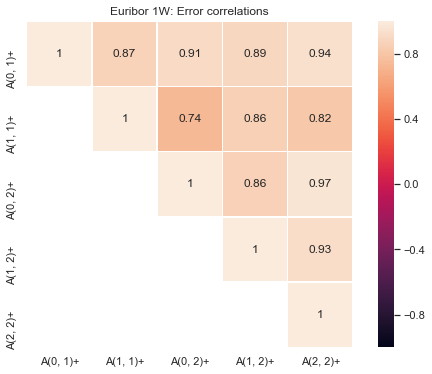

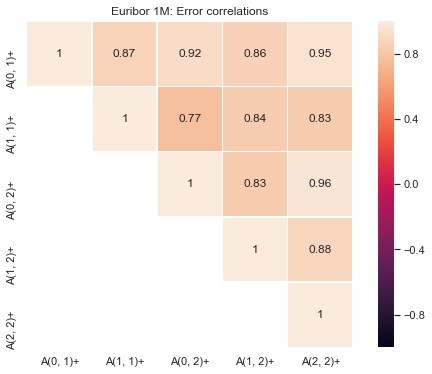

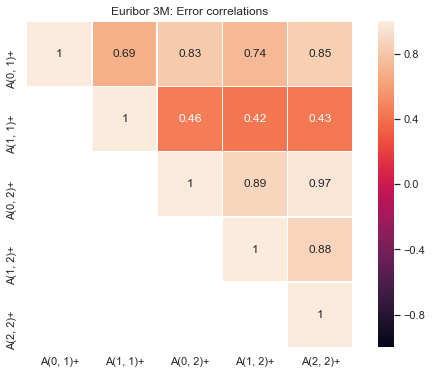

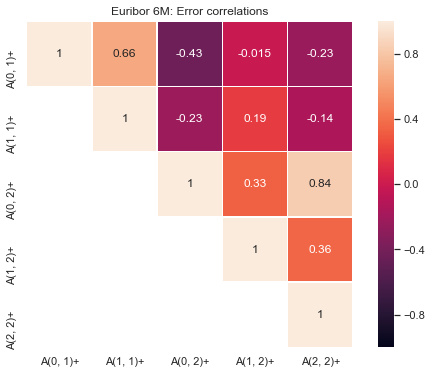

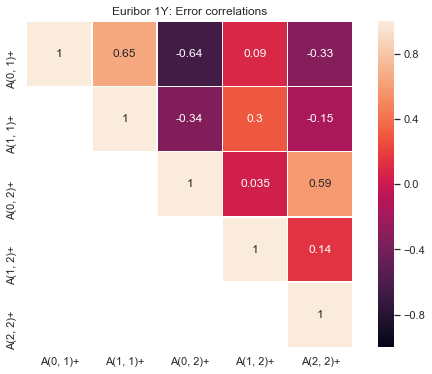

In [32]:
def correlation_heatmap(df, title=None, vmin=-1, vmax=1):

    corr = df.astype(float).corr()
    corr = corr.round(3)
    mask = np.zeros_like(corr)
    mask[np.tril_indices_from(mask, -1)] = True
    
    f, ax = plt.subplots(figsize=(9, 6))
    if isinstance(title, str):
        ax.set_title(title)
        
    sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=.5, ax=ax, vmin=vmin, vmax=vmax)

errors_for_corr = pd.concat(errors, axis=0).reset_index()
errors_for_corr.columns = ['Date', 'Maturity'] + cols

for maturity in ('1W', '1M', '3M', '6M', '1Y'):
    temp_df = errors_for_corr[errors_for_corr['Maturity'] == maturity]
    correlation_heatmap(temp_df.iloc[:, 2:], title=f'Euribor {maturity}: Error correlations')


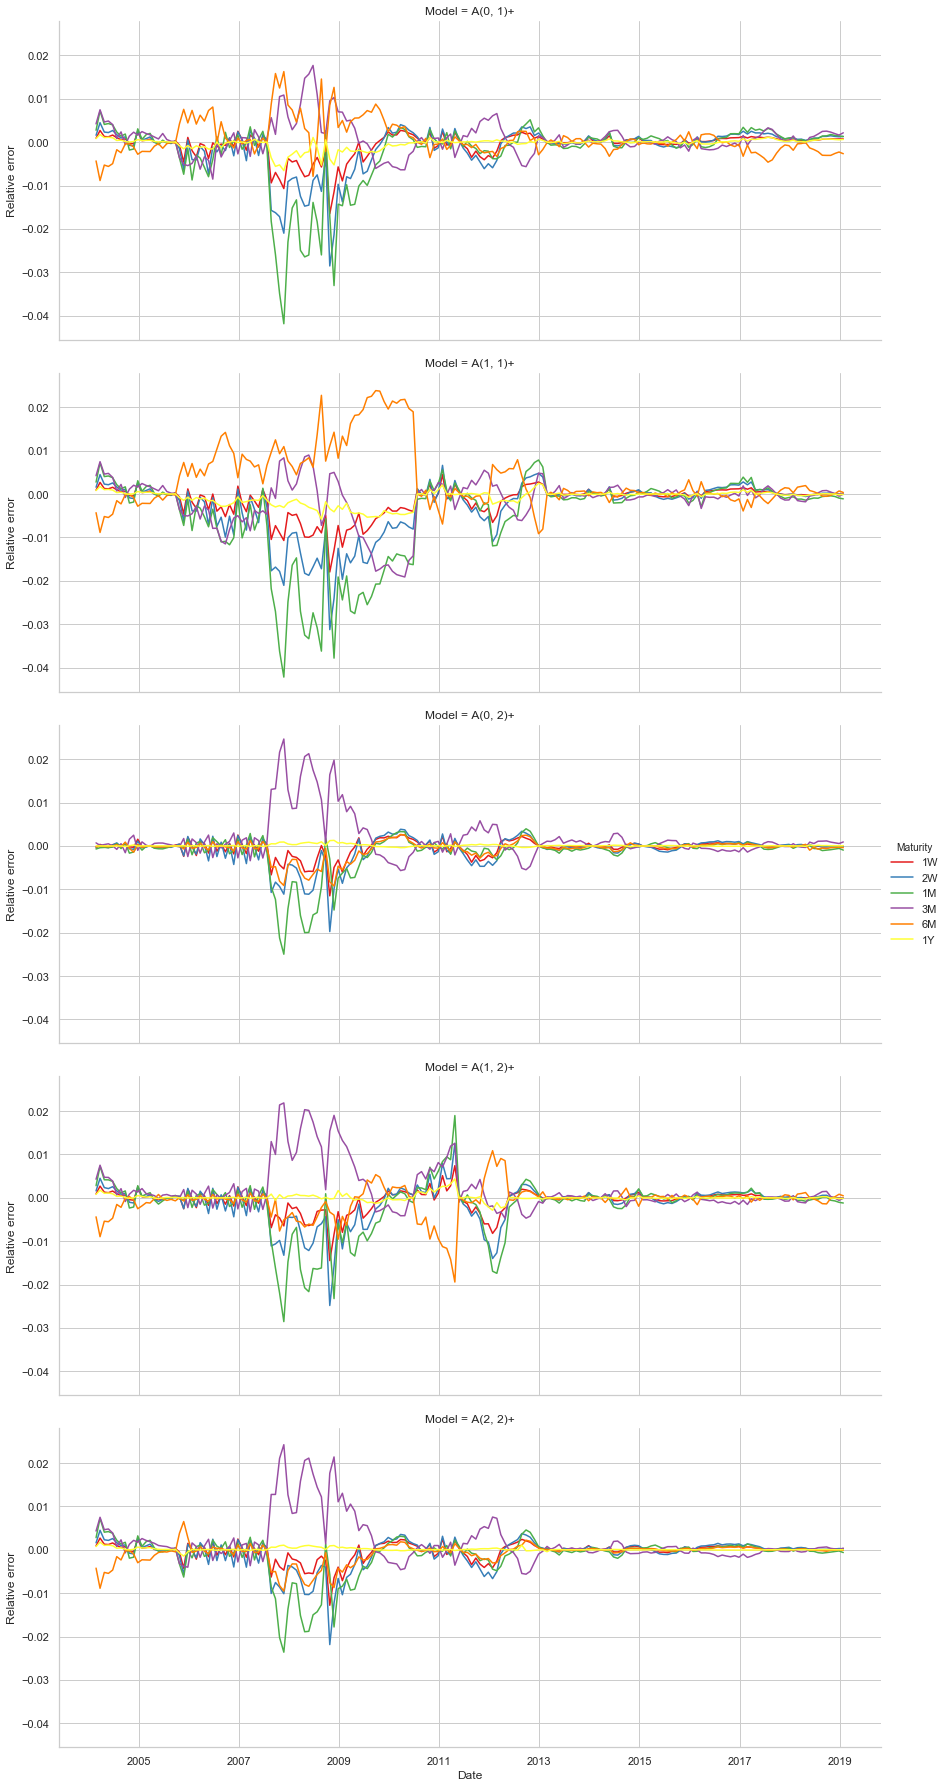

In [4]:
sns.set(style='whitegrid')
g = sns.FacetGrid(errors_df, 
                  row='Model', 
                  hue='Maturity', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1',
                  row_order=['A(0, 1)+', 'A(1, 1)+', 'A(0, 2)+', 'A(1, 2)+', 'A(2, 2)+'])
g = (g.map(sns.lineplot, 'Date', 'Relative error').add_legend())





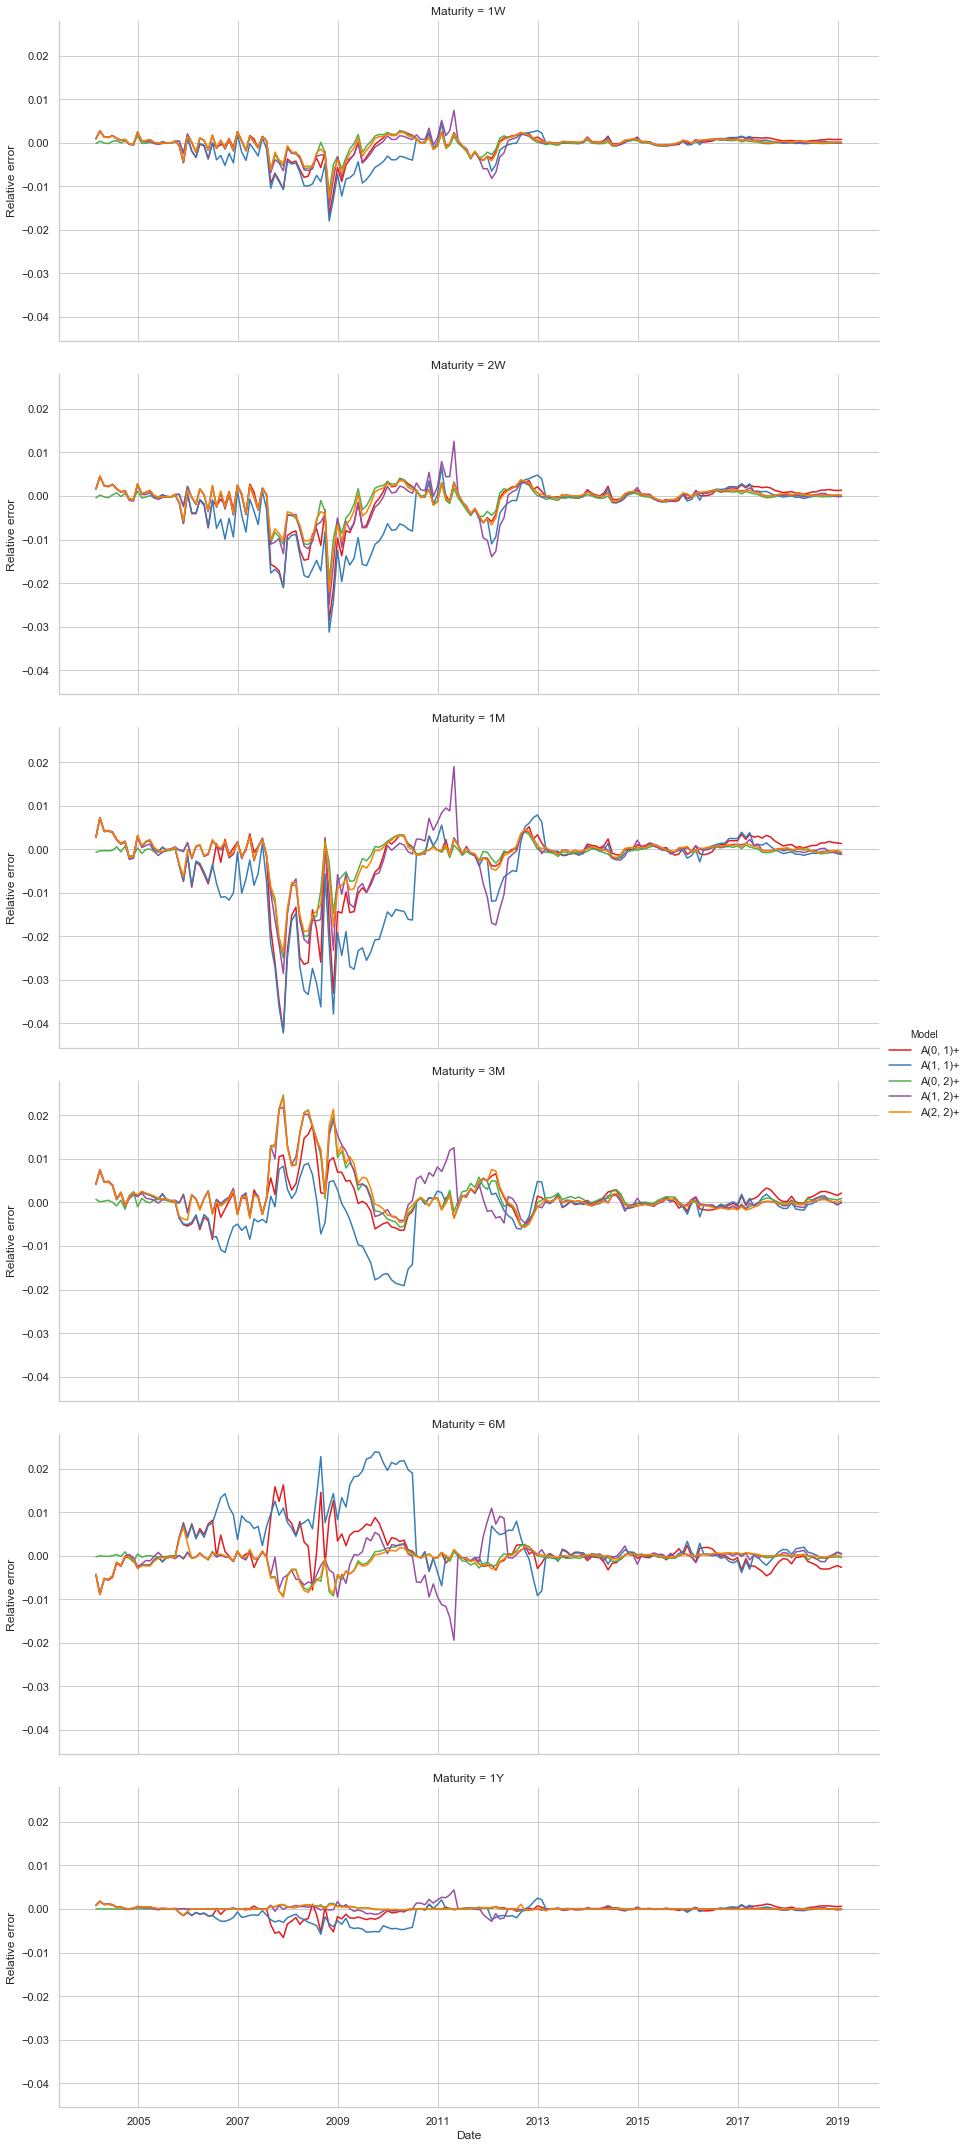

In [5]:
sns.set(style='whitegrid')
g = sns.FacetGrid(errors_df, 
                  row='Maturity', 
                  hue='Model', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Relative error').add_legend())

\begin{tabular}{lr}
\toprule
{} &  Relative error \\
Model    &                 \\
\midrule
A(0, 1)+ &        0.002464 \\
A(0, 2)+ &        0.001577 \\
A(1, 1)+ &        0.003749 \\
A(1, 2)+ &        0.002225 \\
A(2, 2)+ &        0.001755 \\
\bottomrule
\end{tabular}



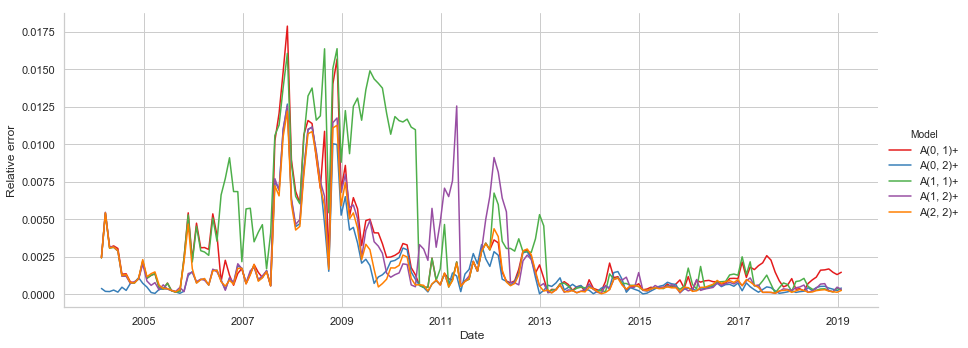

In [8]:
errors_df['Relative error'] = abs(errors_df['Relative error'])
errors_df2 = errors_df.groupby(['Model', 'Date']).mean().reset_index()

sns.set(style='whitegrid')
g = sns.FacetGrid(errors_df2, 
                  hue='Model', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Relative error').add_legend())
print(errors_df2.groupby('Model').mean().to_latex())

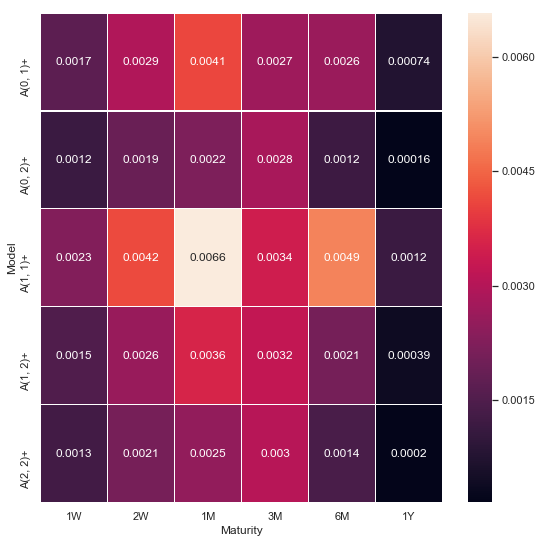

In [29]:
errors_df3 = errors_df.groupby(['Model', 'Maturity']).mean().reset_index()
errors3 = errors_df3.pivot(index='Model', columns='Maturity', values='Relative error')
errors3 = errors3[['1W', '2W', '1M', '3M', '6M', '1Y']]

f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(errors3, annot=True, linewidths=.5, ax=ax)

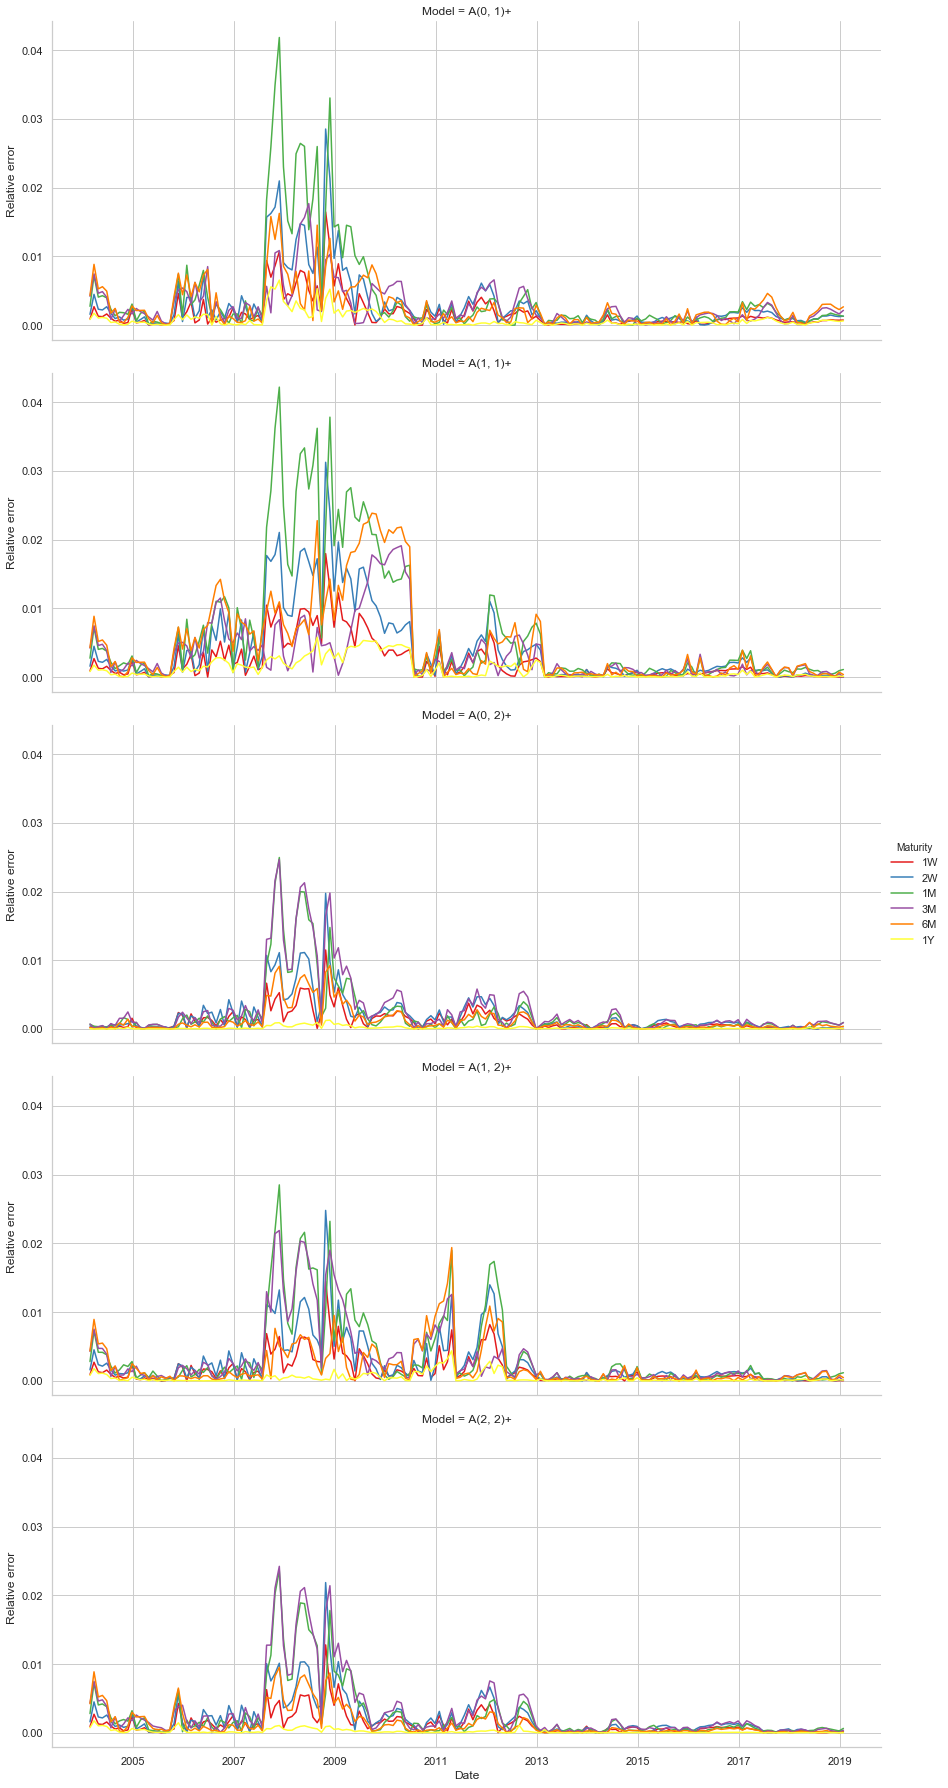

In [35]:
sns.set(style='whitegrid')
g = sns.FacetGrid(errors_df,
                  row='Model',
                  hue='Maturity', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Relative error').add_legend())


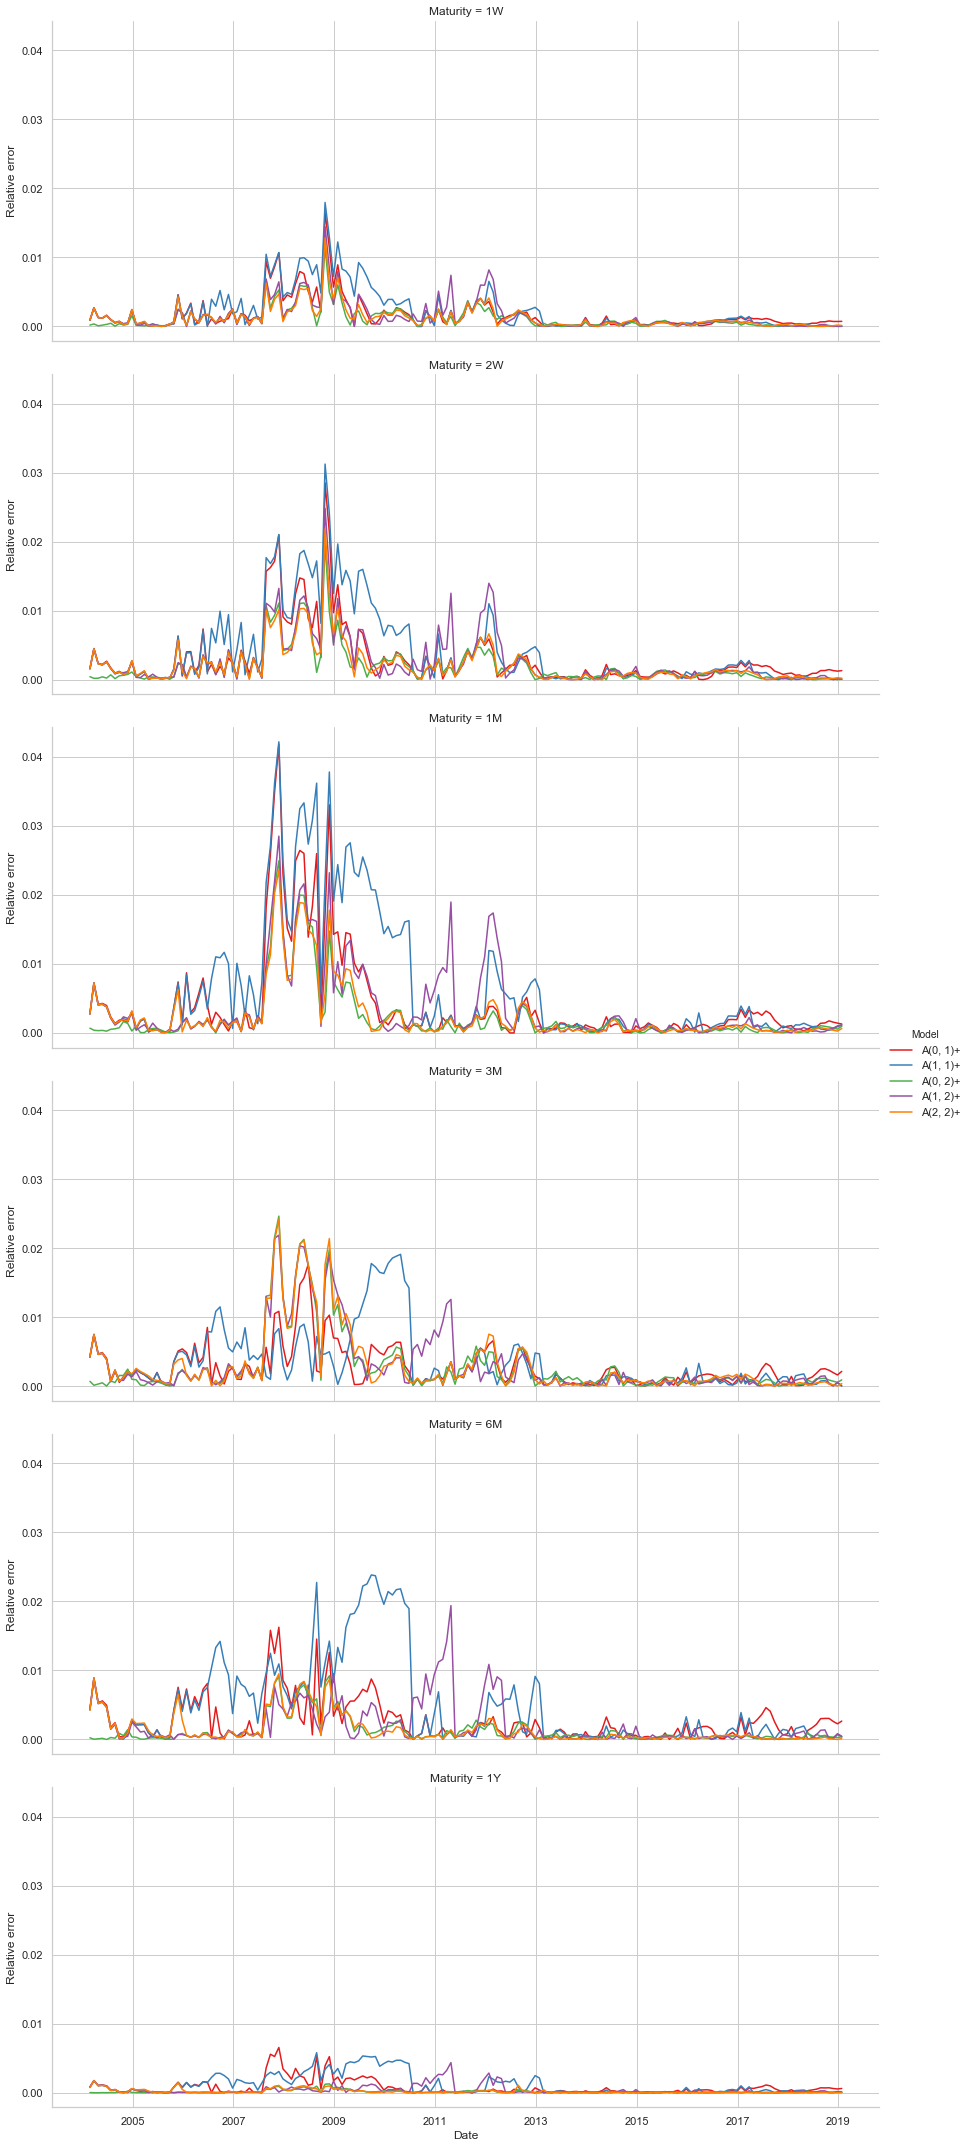

In [36]:
sns.set(style='whitegrid')
g = sns.FacetGrid(errors_df,
                  row='Maturity',
                  hue='Model', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Relative error').add_legend())

In [106]:
for date in results01:
    for key in results01[date]:      
        if key in ('k', 'nu', 'Y_0'):
            results01[date][key] = results01[date][key][0]
        
for date in results11:
    for key in results11[date]:
        if key in ('alpha', 'theta', 'sigma', 'X_0'):
            results11[date][key] = results11[date][key][0]
        
for date in results12:
    for key in results12[date]:
        if key in ('k', 'nu', 'Y_0'):
            results12[date][key] = results12[date][key][0]
        if key in ('alpha', 'theta', 'sigma', 'X_0'):
            results12[date][key] = results12[date][key][0]
            
for date in results02:
    data = results02[date]
    a = data.pop('k')
    data['k1'], data['k2'] = a
    a = data.pop('nu')
    data['nu1'], data['nu2'] = a
    a = data.pop('Y_0')
    data['Y_01'], data['Y_02'] = a
    a = data.pop('rho')[0][1]
    data['rho'] = a
                                          
for date in results22:
    data = results22[date]
    a = data.pop('alpha')
    data['alpha1'], data['alpha2'] = a
    a = data.pop('sigma')
    data['sigma1'], data['sigma2'] = a
    a = data.pop('X_0')
    data['X_01'], data['X_02'] = a
    a = data.pop('theta')
    data['theta1'], data['theta2'] = a


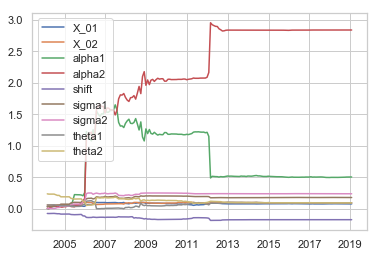

In [107]:
pd.DataFrame(results22).transpose().plot()

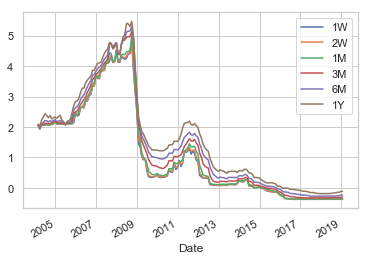

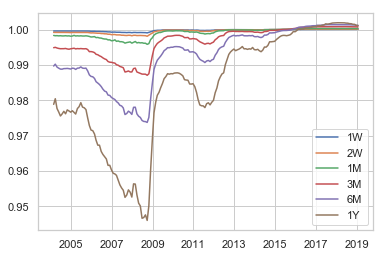

In [108]:
euribor_indexed.plot()

zeros = {}
for date in d:
    zeros[date] = [zero.calibrate for zero in d[date]['zeros']]
df2 = pd.DataFrame(zeros).transpose()
df2.columns = euribor_indexed.columns
df2.plot()

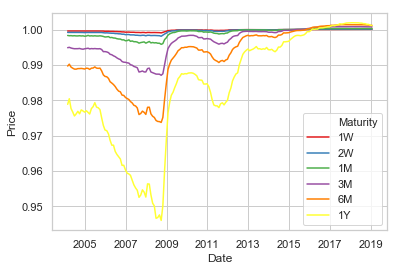

In [109]:
df_zero = pd.DataFrame(zeros).transpose()
df_zero = df_zero.reset_index()
df_zero.columns = ['Date'] + list(euribor_indexed.columns)
df_zeroes = df_zero.melt(id_vars=['Date'], value_vars=df_zero.columns[1:], value_name='Price', var_name='Maturity')

sns.set(style='whitegrid')
sns.lineplot(x='Date', y='Price', hue='Maturity', palette='Set1', data=df_zeroes)

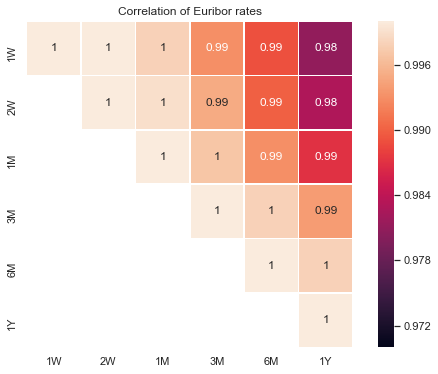

In [110]:
def correlation_heatmap(df, title=None, vmin=-1, vmax=1):

    corr = df.astype(float).corr()
    corr = corr.round(3)
    mask = np.zeros_like(corr)
    mask[np.tril_indices_from(mask, -1)] = True
    
    f, ax = plt.subplots(figsize=(9, 6))
    if isinstance(title, str):
        ax.set_title(title)
        
    sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=.5, ax=ax, vmin=vmin, vmax=vmax)

correlation_heatmap(df_zero.iloc[:,1:], title='Correlation of Euribor rates', vmin=0.97)

In [111]:
results = pd.concat([pd.DataFrame(results01), 
                     pd.DataFrame(results11), 
                     pd.DataFrame(results02), 
                     pd.DataFrame(results12), 
                     pd.DataFrame(results22)],
                    keys=['A(0, 1)+', 'A(1, 1)+', 'A(0, 2)+', 'A(1, 2)+', 'A(2, 2)+'])

results = results.reset_index()
results.columns = ['Model', 'Variable'] + list(results.columns[2:])
results = results.melt(id_vars=['Model', 'Variable'], value_vars=results.columns[2:], value_name='Calibration', var_name='Date')


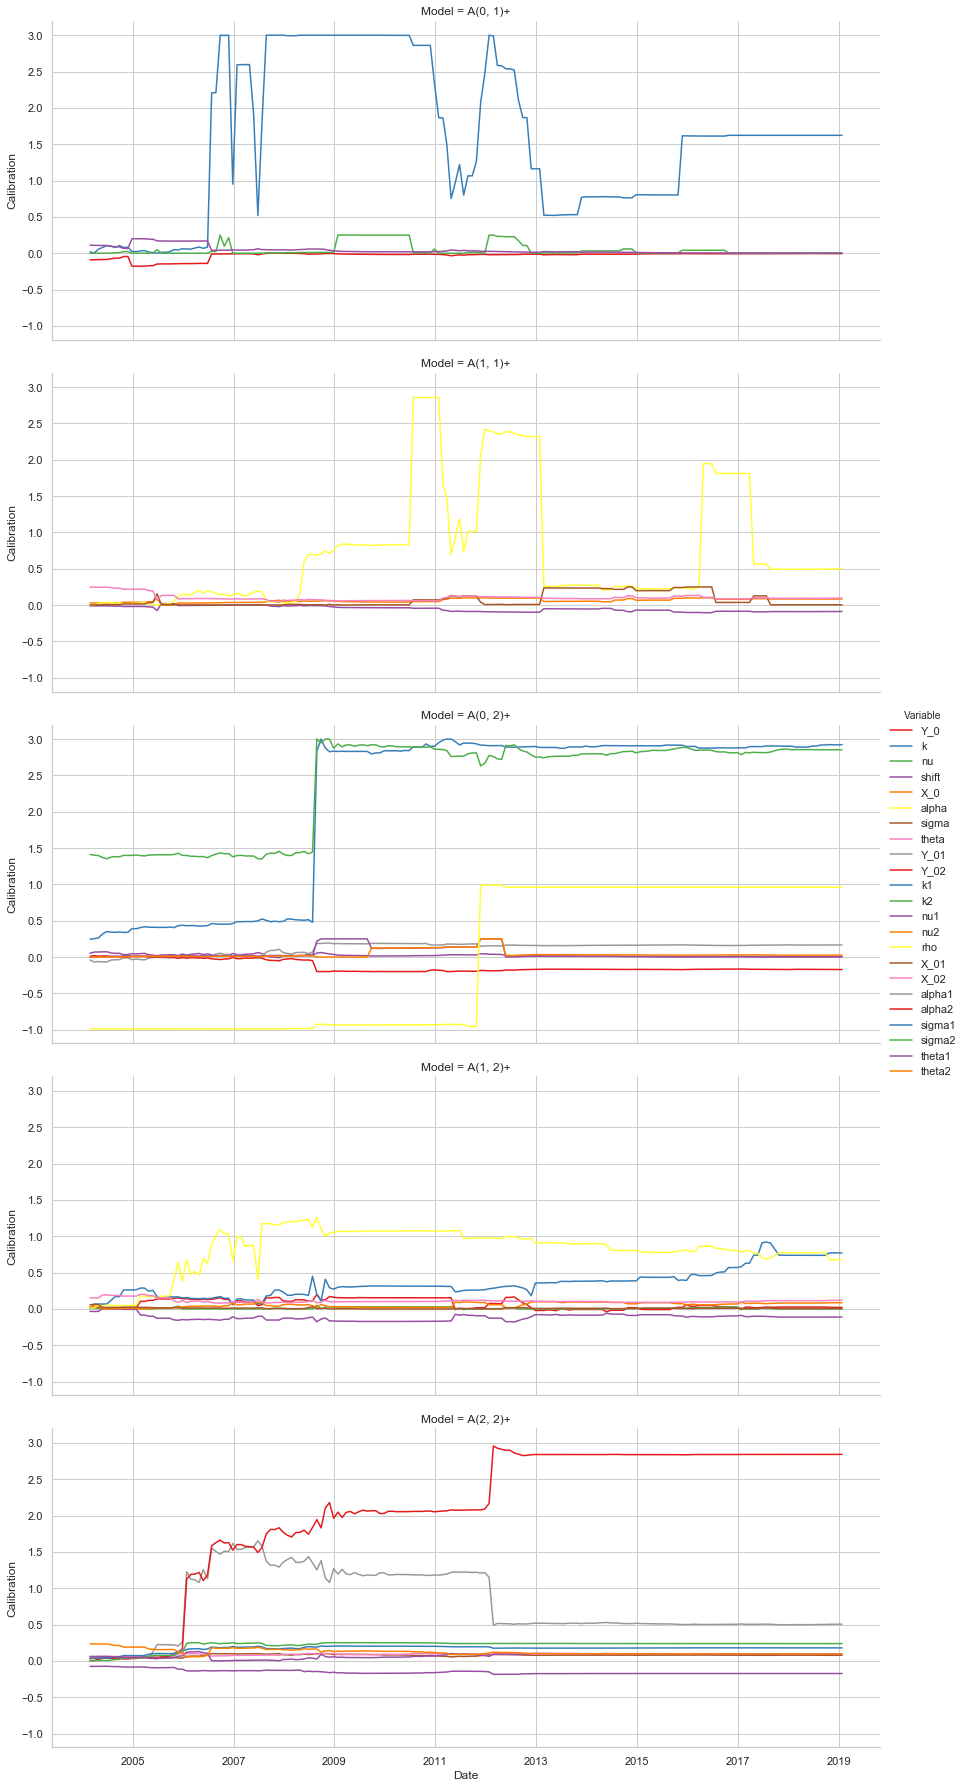

In [112]:
sns.set(style='whitegrid')
g = sns.FacetGrid(results, 
                  row='Model', 
                  hue='Variable', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1',
                  row_order=['A(0, 1)+', 'A(1, 1)+', 'A(0, 2)+', 'A(1, 2)+', 'A(2, 2)+'])
g = (g.map(sns.lineplot, 'Date', 'Calibration').add_legend())

In [39]:
sns.set(style='whitegrid')

for var in set(results['Variable']):
    data = results[results['Variable'] == var]

    g = sns.FacetGrid(data, 
                      hue='Model', 
                      height=5, 
                      aspect=2.5, 
                      palette='Set1',
                      sharey=False,
                      title=f'{var}')
    g = (g.map(sns.lineplot, 'Date', 'Calibration').add_legend())

TypeError: tuple indices must be integers or slices, not str

In [40]:
def curve_modifying(curve_object):
    today = curve_object.today
    df = curve_object.interpolate()
    zeros = df['Zeros']
    rates = df['Rates']
    
    zeros.index = [(day - today).days / 360 for day in list(zeros.index)]
    rates.index = [(day - today).days / 360 for day in list(rates.index)]
    
    return zeros, rates, today

rate_curves = {}

for day in [min(euribor['Date']).date(),
            datetime.date(2005, 1, 26),
            datetime.date(2006, 1, 26),
            datetime.date(2007, 1, 26),
            datetime.date(2008, 1, 26),
            max(euribor_indexed.idxmax()).date(),
            datetime.date(2009, 1, 26),
            datetime.date(2010, 1, 26),
            datetime.date(2011, 1, 26),
            datetime.date(2012, 1, 26),
            datetime.date(2013, 1, 26),
            datetime.date(2014, 1, 26),
            datetime.date(2015, 1, 26),
            datetime.date(2016, 1, 26),
            datetime.date(2017, 1, 26),
            datetime.date(2018, 1, 26),
            datetime.date(2019, 1, 26)]:
    
    zeros, rates, _ = curve_modifying(d[day]['curve'])
    
    rate_curves[day] = pd.DataFrame([zeros, rates]).transpose()

curves = pd.concat(rate_curves).reset_index()
curves.columns = ['Date', 'Maturity', 'Zeros', 'Rates']
curves = curves.melt(id_vars=['Date', 'Maturity'], value_vars=['Zeros', 'Rates'], value_name='Value', var_name='Type')

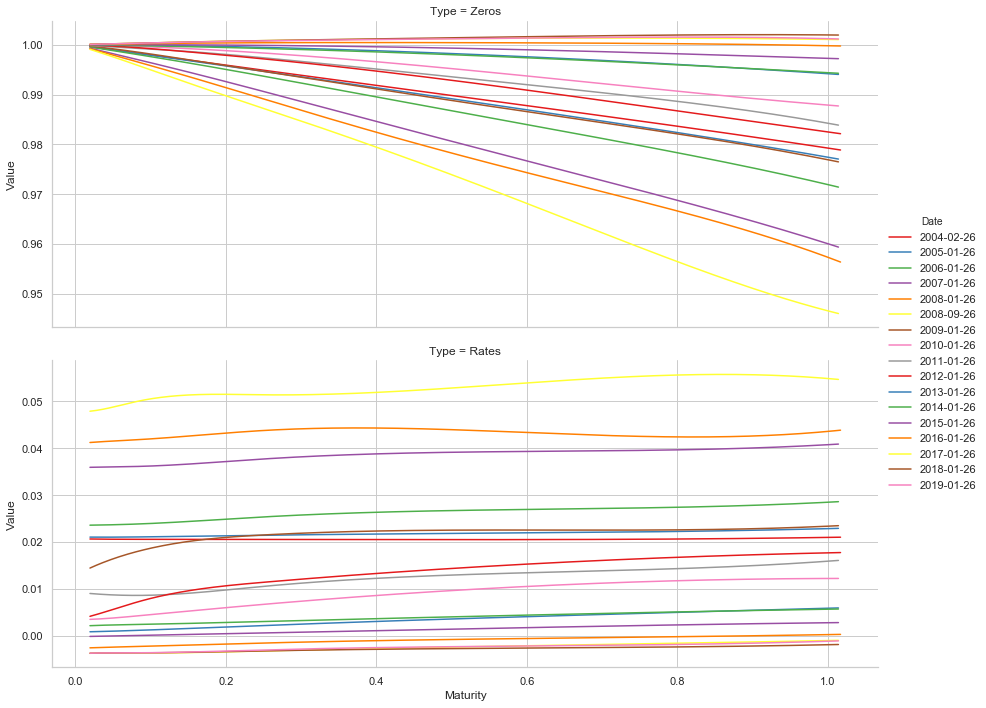

In [41]:
sns.set(style='whitegrid')
g = sns.FacetGrid(curves, 
                  row='Type', 
                  hue='Date', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1',
                  sharey=False)
g = (g.map(sns.lineplot, 'Maturity', 'Value').add_legend())

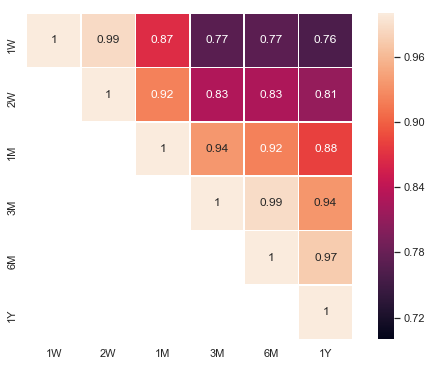

In [42]:
c = euribor.diff().corr()

mask = np.zeros_like(c)
mask[np.tril_indices_from(mask, -1)] = True
  
f, ax = plt.subplots(figsize=(9, 6))
        
sns.heatmap(c, annot=True, mask=mask, square=True, linewidths=.5, ax=ax, vmin=0.7, vmax=1)


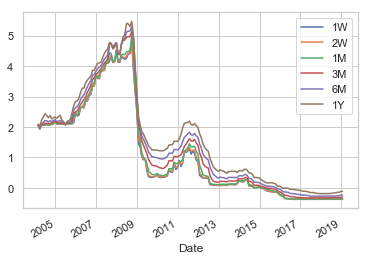

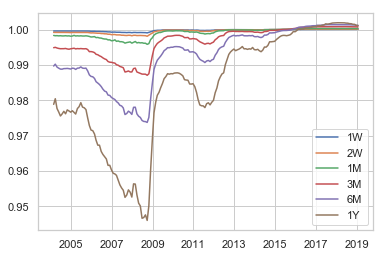

In [43]:
euribor_indexed.plot()

zeros = {}
for date in d:
    zeros[date] = [zero.calibrate for zero in d[date]['zeros']]
df2 = pd.DataFrame(zeros).transpose()
df2.columns = euribor_indexed.columns
df2.plot()

## 

In [116]:
d2009 = datetime.date(2009, 1, 1)
d2011 = datetime.date(2011, 1, 1)
d2013 = datetime.date(2013, 1, 1)
d2015 = datetime.date(2015, 1, 1)
highest_rate_date = df2['1Y'].idxmin()

def karsi_ajan_mukaan(df, upper, lower, column, minmax):
    df_ala = df[df.index > lower]
    df_yla = df_ala[df_ala < upper]
    
    if minmax == 'min':
        return df_yla[column].argmin()
    else:
        return df_yla[column].argmin()

before_crisis = df2[ df2.index < d2009 ]['1Y'].argmin()
after_crisis = karsi_ajan_mukaan(df2, d2011, d2009, '1Y', 'max')
tapering = karsi_ajan_mukaan(df2, d2013, d2011, '1Y', 'min')



before_crisis, after_crisis, tapering

C:\Users\Miikka\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()
C:\Users\Miikka\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  
C:\Users\Miikka\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  if sys.path[0] == '':


(datetime.date(2008, 9, 26),
 datetime.date(2009, 1, 26),
 datetime.date(2011, 7, 26))

In [122]:
def vertaa(date):
    if date < before_crisis:
        return 'Pre-crisis'
    elif date < after_crisis:
        return 'Dropping rates during crisis'
    elif date < tapering:
        return 'Post-crisis rising rates'
    else:
        return 'Toward negative rates'
    
errors_df['Period'] = errors_df['Date'].apply(vertaa)
errors_df

,Date,Maturity,Model,Relative error,Period
0,2004-02-26,1W,"A(0, 1)+",8.988581e-04,Pre-crisis
1,2004-02-26,2W,"A(0, 1)+",1.578522e-03,Pre-crisis
2,2004-02-26,1M,"A(0, 1)+",2.745756e-03,Pre-crisis
3,2004-02-26,3M,"A(0, 1)+",4.212109e-03,Pre-crisis
4,2004-02-26,6M,"A(0, 1)+",4.330659e-03,Pre-crisis
5,2004-02-26,1Y,"A(0, 1)+",8.243104e-04,Pre-crisis
6,2004-03-26,1W,"A(0, 1)+",2.693938e-03,Pre-crisis
7,2004-03-26,2W,"A(0, 1)+",4.485984e-03,Pre-crisis
8,2004-03-26,1M,"A(0, 1)+",7.223649e-03,Pre-crisis
9,2004-03-26,3M,"A(0, 1)+",7.465025e-03,Pre-crisis


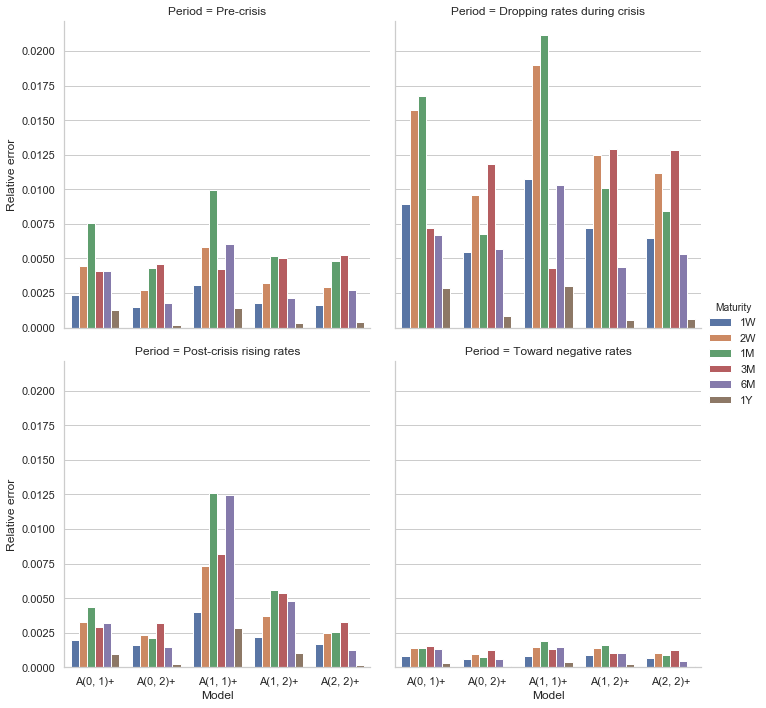

In [123]:
errors_df3 = errors_df.groupby(['Model', 'Period', 'Maturity']).mean().reset_index()
errors_df3

g =sns.catplot(x='Model', 
               y='Relative error', 
               col='Period',
               hue='Maturity',
               col_wrap=2,
               col_order=['Pre-crisis', 'Dropping rates during crisis', 'Post-crisis rising rates', 'Toward negative rates'], 
               hue_order=['1W', '2W', '1M', '3M', '6M', '1Y'],
               kind='bar', 
               data=errors_df3)